In [1]:
# fix python path if working locally
from helpers import fix_pythonpath_if_working_locally
fix_pythonpath_if_working_locally()

import requests
import io
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import datetime as dt

from darts import TimeSeries
from darts.models import (
    BlockRNNModel,
)
from darts.utils.missing_values import fill_missing_values
from darts.dataprocessing.transformers import Scaler

# for reproducibility
torch.manual_seed(1)
np.random.seed(1)


In [2]:
# Importing Training Set
def loadDataset(url):
    s=requests.get(url).content
    dataset = data=pd.read_csv(io.StringIO(s.decode('utf-8')))
    dataset.livingroom_window_open = dataset.livingroom_window_open.replace({True: 1, False: 0})
    dataset.livingroom_door_open = dataset.livingroom_window_open.replace({True: 1, False: 0})
    dataset.balcony_door_open = dataset.livingroom_door_open.replace({True: 1, False: 0})
    dataset.kitchen_window_open = dataset.kitchen_window_open.replace({True: 1, False: 0})
    dataset.timestamp = pd.Series([dt.datetime.strptime(date, '%Y-%m-%dT%H:%M:%S.%fZ') for date in list(dataset['timestamp'])]).round("10S")

    # Select features (columns) to be involved intro training and predictions
    cols = ["timestamp", "co2", "livingroom_window_open", "livingroom_door_open", "balcony_door_open", "kitchen_window_open", "rtemperature", "rhumidity", "temperature_outdoor", "humidity_outdoor"]
    return dataset[cols].drop_duplicates(subset=['timestamp'], keep='last')

In [3]:
dataset = loadDataset("https://iaq-data.brgr.rocks/full.csv")
print(dataset.tail)

<bound method NDFrame.tail of                  timestamp     co2  livingroom_window_open  \
0      2022-05-03 16:12:40  606.62                       0   
1      2022-05-03 16:12:50  605.24                       0   
2      2022-05-03 16:13:00  604.32                       0   
3      2022-05-03 16:13:10  604.82                       0   
4      2022-05-03 16:13:20  606.36                       0   
...                    ...     ...                     ...   
520374 2022-07-10 03:59:50  466.78                       0   
520375 2022-07-10 04:00:00  467.83                       0   
520376 2022-07-10 04:00:10  467.39                       0   
520377 2022-07-10 04:00:20  467.02                       0   
520378 2022-07-10 04:00:30  466.49                       0   

        livingroom_door_open  balcony_door_open  kitchen_window_open  \
0                          0                  0                    0   
1                          0                  0                    0   
2        

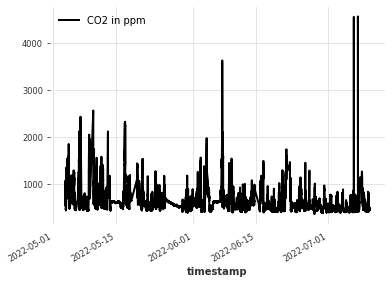

In [4]:
# series to predict, in this case CO2
series_co2 = fill_missing_values(TimeSeries.from_dataframe(dataset, 'timestamp', 'co2', fill_missing_dates=True, freq="10s" ), fill='auto')

# covariates to help predict the CO2 series
covariates_livingroom_door_open = fill_missing_values(TimeSeries.from_dataframe(dataset, 'timestamp', 'livingroom_door_open', fill_missing_dates=True, freq="10s"), fill='auto')
covariates_balcony_door_open = fill_missing_values(TimeSeries.from_dataframe(dataset, 'timestamp', 'balcony_door_open', fill_missing_dates=True, freq="10s"), fill='auto')
covariates_livingroom_window_open = fill_missing_values(TimeSeries.from_dataframe(dataset, 'timestamp', 'livingroom_window_open', fill_missing_dates=True, freq="10s"), fill='auto')
covariates_kitchen_window_open = fill_missing_values(TimeSeries.from_dataframe(dataset, 'timestamp', 'kitchen_window_open', fill_missing_dates=True, freq="10s"), fill='auto')
covariates_temperature_indoors = fill_missing_values(TimeSeries.from_dataframe(dataset, 'timestamp', 'rtemperature', fill_missing_dates=True, freq="10s"), fill='auto')
covariates_humidity_indoors = fill_missing_values(TimeSeries.from_dataframe(dataset, 'timestamp', 'rhumidity', fill_missing_dates=True, freq="10s"), fill='auto')
covariates_temperature_outdoors = fill_missing_values(TimeSeries.from_dataframe(dataset, 'timestamp', 'temperature_outdoor', fill_missing_dates=True, freq="10s"), fill='auto')
covariates_humidity_outdoors = fill_missing_values(TimeSeries.from_dataframe(dataset, 'timestamp', 'humidity_outdoor', fill_missing_dates=True, freq="10s"), fill='auto')

series_co2.plot(label="CO2 in ppm")
plt.legend()

In [8]:
scaler = Scaler()
series_co2_scaled = scaler.fit_transform(series_co2)
covariates_livingroom_door_open_scaled, covariates_balcony_door_open_scaled, covariates_livingroom_window_open_scaled, covariates_kitchen_window_open_scaled, covariates_temperature_indoors_scaled, covariates_humidity_indoors_scaled, covariates_temperature_outdoors_scaled, covariates_humidity_outdoors_scaled = scaler.fit_transform([covariates_livingroom_door_open, covariates_balcony_door_open, covariates_livingroom_window_open, covariates_kitchen_window_open, covariates_temperature_indoors, covariates_humidity_indoors, covariates_temperature_outdoors, covariates_humidity_outdoors])

In [9]:
train_split = 574087
test_split = len(series_co2_scaled)-train_split
print(test_split)

# training data
train_series_co2 = series_co2_scaled[:train_split]
train_covariates_livingroom_door_open = covariates_balcony_door_open_scaled[:train_split]
train_covariates_balcony_door_open = covariates_balcony_door_open_scaled[:train_split]
train_covariates_livingroom_window_open = covariates_livingroom_window_open_scaled[:train_split]
train_covariates_kitchen_window_open = covariates_kitchen_window_open_scaled[:train_split]
train_covariates_temperature_indoors = covariates_temperature_indoors_scaled[:train_split]
train_covariates_humidity_indoors = covariates_humidity_indoors_scaled[:train_split]
train_covariates_temperature_outdoors = covariates_temperature_outdoors_scaled[:train_split]
train_covariates_humidity_outdoors = covariates_humidity_outdoors_scaled[:train_split]
train_covariates = train_covariates_livingroom_door_open.stack(train_covariates_balcony_door_open).stack(train_covariates_livingroom_window_open).stack(train_covariates_kitchen_window_open).stack(train_covariates_temperature_indoors).stack(train_covariates_humidity_indoors).stack(train_covariates_temperature_outdoors).stack(train_covariates_humidity_outdoors)

# test data
test_series_co2 = series_co2_scaled[-test_split:]
test_covariates_livingroom_door_open = covariates_balcony_door_open_scaled[-train_split:]
test_covariates_balcony_door_open = covariates_balcony_door_open_scaled[-train_split:]
test_covariates_livingroom_window_open = covariates_livingroom_window_open_scaled[-train_split:]
test_covariates_kitchen_window_open = covariates_kitchen_window_open_scaled[-train_split:]
test_covariates_temperature_indoors = covariates_temperature_indoors_scaled[-train_split:]
test_covariates_humidity_indoors = covariates_humidity_indoors_scaled[-train_split:]
test_covariates_temperature_outdoors = covariates_temperature_outdoors_scaled[-train_split:]
test_covariates_humidity_outdoors = covariates_humidity_outdoors_scaled[-train_split:]
test_covariates = test_covariates_livingroom_door_open.stack(test_covariates_balcony_door_open).stack(test_covariates_livingroom_window_open).stack(test_covariates_kitchen_window_open).stack(test_covariates_temperature_indoors).stack(test_covariates_humidity_indoors).stack(test_covariates_temperature_outdoors).stack(test_covariates_humidity_outdoors)

9041


In [153]:
model_co2 = BlockRNNModel(
    model="GRU",
    input_chunk_length=90,
    output_chunk_length=90,
    batch_size=90,
    n_epochs=50,
    random_state=0,
    dropout=0.1,
    model_name="GRU",
    pl_trainer_kwargs={
      "accelerator": "gpu",
      "gpus": [0]
    },
    nr_epochs_val_period=1,
    optimizer_kwargs={"lr": 1e-3},
    log_tensorboard=True,
    force_reset=True,
)

In [154]:
model_co2.fit(series=train_series_co2, past_covariates=train_covariates, verbose=True)

2022-07-10 00:05:13 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 573908 samples.
C:\Users\lunar\AppData\Roaming\Python\Python39\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
2022-07-10 00:05:13 darts.models.forecasting.torch_forecasting_model INFO: Time series values are 64-bits; casting model to float64.
2022-07-10 00:05:13 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-07-10 00:05:13 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-07-10 00:05:13 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-07-10 00:05:13 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
C:\Users\lunar\AppData\Roam

Training: 0it [00:00, ?it/s]

C:\Users\lunar\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\trainer.py:726: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [62]:
model_co2.save_model('co2.pth.tar')

In [5]:
model_co2 = BlockRNNModel.load_model('co2.pth.tar')

C:\Users\lunar\AppData\Roaming\Python\Python39\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


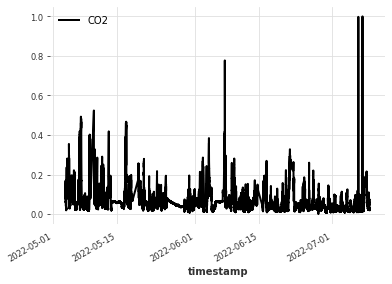

In [64]:
dataset = loadDataset("https://iaq-data.brgr.rocks/full.csv")

covariates_livingroom_door_open = TimeSeries.from_dataframe(dataset, 'timestamp', 'livingroom_door_open', fill_missing_dates=True, freq="10s")
covariates_balcony_door_open = TimeSeries.from_dataframe(dataset, 'timestamp', 'balcony_door_open', fill_missing_dates=True, freq="10s")
series_co2 = TimeSeries.from_dataframe(dataset, 'timestamp', 'co2', fill_missing_dates=True, freq="10s" )
covariates_livingroom_door_open = fill_missing_values(covariates_livingroom_door_open, fill='auto')
covariates_balcony_door_open = fill_missing_values(covariates_balcony_door_open, fill='auto')
series_co2 = fill_missing_values(series_co2, fill='auto')

scaler = Scaler()
series_co2_scaled, covariates_livingroom_door_open_scaled, covariates_balcony_door_open_scaled = scaler.fit_transform([series_co2, covariates_livingroom_door_open, covariates_balcony_door_open])

series_co2_scaled.plot(label="CO2")
plt.legend()


Predicting: 110it [00:00, ?it/s]

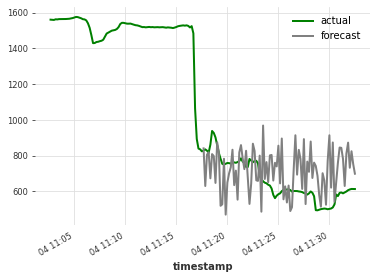

In [145]:
position = 6780
past = 90

train_series_co2_part = series_co2_scaled[position:(position+past)]
train_covariates_part = train_covariates[position:(position+past)]

actual_co2 = series_co2_scaled[position:(position+past*2)]

pred_list_scaled = model_co2.predict(n=past, series=train_series_co2_part, past_covariates=train_covariates_part)

pred_list = scaler.inverse_transform(pred_list_scaled)
series_air = scaler.inverse_transform(series_co2_scaled)
series_actual = scaler.inverse_transform(actual_co2)

series_actual.plot(label="actual", color="green")
pred_list.plot(label="forecast", color="grey")
plt.legend()

In [ ]:
from darts import metrics

historical_fcast = model_co2.historical_forecasts(
 series=test_series_co2, past_covariates=test_covariates, start=90, forecast_horizon=90, verbose=False, retrain=False, overlap_end=False
)

series_co2_real = scaler.inverse_transform(test_series_co2[180:])
historical_fcast_real = scaler.inverse_transform(historical_fcast)

series_co2_real.plot(label="actual")
historical_fcast_real.plot(label="predicted")

print(metrics.metrics.mae(series_co2_real, historical_fcast_real))

2022-07-10 17:39:59 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: True
2022-07-10 17:39:59 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-07-10 17:39:59 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-07-10 17:39:59 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-07-10 17:40:02 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\lunar\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:49 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:49 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:49 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:49 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:49 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:49 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:49 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:49 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:49 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:49 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:49 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:49 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:49 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:49 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:49 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:52 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:52 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:52 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:52 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:52 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:52 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:52 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:52 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:52 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:52 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:52 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:52 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:52 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:52 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:52 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:52 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:54 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:54 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:54 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:54 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:54 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:54 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:54 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:54 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:54 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:54 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:54 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:54 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:54 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:54 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:54 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:54 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:55 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:55 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:55 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:55 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:55 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:55 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:55 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:55 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:55 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:55 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:55 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:55 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:55 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:55 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:55 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:55 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:40:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:00 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:00 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:00 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:00 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:00 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:00 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:00 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:00 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:00 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:00 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:00 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:00 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:00 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:00 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:00 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:00 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:00 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:02 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:02 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:02 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:02 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:02 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:02 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:02 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:02 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:02 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:02 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:02 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:02 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:02 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:02 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:02 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:02 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:02 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:49 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:49 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:49 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:49 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:49 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:49 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:52 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:52 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:52 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:52 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:54 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:54 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:54 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:54 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:54 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:55 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:55 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:55 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:55 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:55 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:55 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:41:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:00 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:00 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:00 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:00 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:02 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:02 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:02 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:02 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:02 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:02 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:02 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:02 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:49 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:49 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:49 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:49 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:49 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:52 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:52 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:52 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:52 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:52 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:52 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:52 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:52 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:54 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:54 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:54 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:54 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:54 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:54 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:54 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:54 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:54 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:54 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:54 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:54 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:54 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:54 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:55 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:55 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:55 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:55 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:55 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:55 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:55 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:55 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:55 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:55 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:55 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:55 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:55 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:55 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:55 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:42:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:00 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:00 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:00 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:00 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:00 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:00 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:00 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:00 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:02 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:02 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:02 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:02 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:02 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:49 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:49 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:49 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:49 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:49 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:49 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:49 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:49 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:49 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:49 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:49 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:49 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:52 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:52 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:52 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:52 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:52 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:52 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:52 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:52 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:52 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:54 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:54 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:54 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:54 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:54 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:54 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:54 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:55 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:55 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:55 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:55 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:55 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:55 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:55 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:55 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:43:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:00 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:00 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:00 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:00 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:00 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:00 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:00 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:00 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:02 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:02 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:02 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:02 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:02 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:02 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:02 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:02 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:02 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:02 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:02 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:02 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:02 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:49 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:49 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:49 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:49 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:49 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:49 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:49 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:52 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:52 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:52 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:52 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:52 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:54 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:54 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:54 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:54 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:54 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:54 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:54 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:54 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:54 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:54 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:55 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:55 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:55 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:55 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:55 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:55 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:55 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:55 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:55 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:44:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:00 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:00 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:00 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:00 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:00 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:00 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:00 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:00 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:00 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:02 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:02 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:02 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:49 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:49 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:49 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:49 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:49 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:49 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:52 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:52 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:52 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:52 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:52 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:52 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:54 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:54 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:54 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:54 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:55 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:55 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:55 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:55 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:45:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:00 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:00 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:00 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:00 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:00 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:02 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:02 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:02 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:02 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:02 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:49 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:49 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:49 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:49 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:49 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:49 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:52 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:52 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:52 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:54 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:54 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:55 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:55 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:55 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:46:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:00 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:00 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:00 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:00 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:02 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:02 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:02 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:49 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:49 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:49 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:52 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:52 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:54 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:54 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:54 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:54 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:55 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:55 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:55 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:55 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:47:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:48:00 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:48:00 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:48:00 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:48:00 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:48:00 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:48:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:48:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:48:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:48:02 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:48:02 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:48:02 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:48:02 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:48:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:48:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:48:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:48:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:48:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:48:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:48:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:48:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:48:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:48:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:48:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:48:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:48:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:48:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:48:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:48:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:48:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:48:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:48:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:48:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:48:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:48:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:48:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:48:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:48:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:48:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:48:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:48:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:48:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:48:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:48:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:48:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:48:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:48:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:48:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:48:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:48:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:48:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:48:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:48:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:48:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:48:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:48:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:48:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:48:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

2022-07-10 17:48:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [3]:
model_co2 = BlockRNNModel.load_model('co2.pth.tar')

/Users/manuelberger/Documents/dev/github/indoor-air-monitor/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
